In [1]:
using CSV
using DataFrames
using Turing
using MCMCChains
using Plots
using StatsPlots
using StatsBase
using Distributions
using NPZ
using Statistics

## Importing ##

In [2]:
data_path = "spikeAndBehavioralData/allData/Cori_2016-12-14/"
eye_area = npzread("$(data_path)eye.area.npy")
clusterids = npzread("$(data_path)spikes.clusters.npy")[:] 
spiketimes = npzread("$(data_path)spikes.times.npy")[:]
eyetimes = npzread("$(data_path)eye.timestamps.npy")[:,2]

267759-element Vector{Float64}:
   15.982835732952108
   15.992836839228154
   16.0028379455042
   16.012839051780247
   16.022840158056297
   16.03284126433234
   16.042842370608387
   16.052843476884433
   16.06284458316048
   16.072845689436527
   16.082846795712577
   16.092847901988623
   16.10284900826467
    ⋮
 2693.748894411977
 2693.7588955182528
 2693.768896624529
 2693.778897730805
 2693.7888988370814
 2693.7988999433574
 2693.8089010496333
 2693.8189021559097
 2693.828903262185
 2693.8389043684615
 2693.8489054747374
 2693.8589065810133

## Pre-Processing ##

The first step is to process the data for when each cluster spikes into an array. Each row should represent a cluster and each column should represent a time bin. Each entry to the array is the amount of times that that particular neuron spiked over the period of the time bin (e.g. 1 second).

In [3]:
# count spikes for each cluster
unique_clusterids = sort(unique(clusterids))
nclusters = length(unique_clusterids) # number of clusters
binedges = -0.5 .+ append!(unique_clusterids,clusterids[end]+1)
h_spikecounts = StatsBase.fit(Histogram,clusterids[:],binedges)
spikecounts = h_spikecounts.weights
spikerates = spikecounts./maximum(spiketimes)

# get spike counts per timebin
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
spikecount_array = Array{Int64}(undef,nclusters,nt-1)

for i = 1:nclusters
    inds = findall(clusterids.==i)
    htemp = StatsBase.fit(Histogram,spiketimes[:][inds],timebin_edges)
    spikecount_array[i,:] = htemp.weights
end

The second step is to reformat the eye area data to rescale the time frame. This is necessary as the eye area data was captured using a camera the cluster spiketimes was captured using a neuropixel probe, meaning that although they record for the same time period, the time scales are incorrect. 

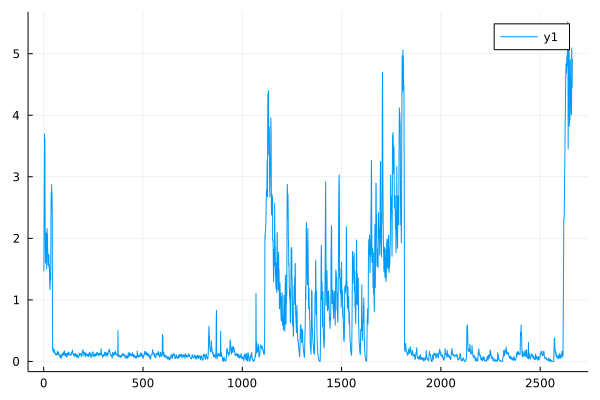

In [4]:
# Remove all negative areas from the eye_area data
for i in 1:length(eye_area)
    if eye_area[i] < 0
        eye_area[i] = 0
    end
end

# Define the bounderies for the timebins for eye areas
dt = 1 # seconds
maxtime = maximum(spiketimes)
timebin_edges = (20:dt:maxtime-20)
nt = length(timebin_edges)
eye_area_bin = zeros(Float32, nt-1)

# Generate the average eye area for each time bin.
j = 1
for i in 1:nt-1
    count = 0
    while eyetimes[j] <= timebin_edges[i+1]
        if eyetimes[j] >= timebin_edges[i]
            eye_area_bin[i] += eye_area[j]
            count += 1
        end
        j += 1
    end
    eye_area_bin[i] /= count
end

plot(eye_area_bin)


We are now left with eye area averages which correspond to the same time period as each spikecount for each neuron. 

The number of clusters is 1085
Number of spikecount timebins is 2662
Number of eye area averages is 2662
There is a Pearson correlation coefficient of 0.2059455 between the two data


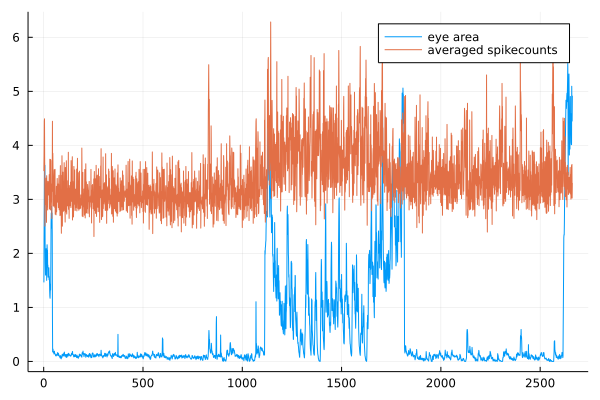

In [5]:
println("The number of clusters is $(length(spikecount_array[:,1]))")
println("Number of spikecount timebins is $(length(spikecount_array[1,:]))")
println("Number of eye area averages is $(length(eye_area_bin))")

summed_spikecounts = zeros(Float32, length(spikecount_array[1,:]))
for cluster in 1:length(spikecount_array[:,1])
    summed_spikecounts += spikecount_array[cluster,:]
end

average_spikecounts = summed_spikecounts ./ length(spikecount_array[:,1])

println("There is a Pearson correlation coefficient of ", cor(average_spikecounts, eye_area_bin), " between the two data")

plot(eye_area_bin, label="eye area")
plot!(average_spikecounts, label="averaged spikecounts")

## Modelling ##

Now that the data is in the desired format a model can be constructed. The spikecounts can be modelled as a Poisson process

$$sc \sim Poisson(\lambda_i)$$

where $i$ is the index of a cluster. The mean rate of firing $\lambda_i$ can be modelled by a Gamma distribution

$$\lambda_i \sim Gamma(k_j, \theta_j)$$

where $j$ is the index of an eye area. The shape of the gamma distribution $k_j$ and $\theta_j$ can be modelled by an Exponential distribution.

$$k_j = g(a + b*eye\_ area)$$
$$\theta_j \sim Gamma(2,2)$$

where g is a function to ensure that $k_j$ is monotonic and positive and $a$ and $b$ are priors modelled by

$$a \sim Gamma(2, 2)$$ 
$$b \sim Normal(0, 1)$$ 

In [6]:
@model function firing_model(eye_area_bin, spikecount_array)
    # Priors
    a ~ Gamma(2, 2)
    b ~ Normal(0, 1)
    theta ~ Gamma(2, 2)

    # Create a vector of k distributions for each eye area
    k = Vector{Float64}(undef, length(eye_area_bin))
    for i in 1:length(eye_area_bin[1,:])
        k[i] = exp(a + b * eye_area_bin[i])
    end

    # Create a vector of k distributions for cluster
    lambda = Vector{Float64}(undef, length(spikecount_array[:,1]))
    for i in 1:length(eye_area_bin[1,:])
        lambda[i] ~ Gamma(k[i], theta)
    end

    # Likelihoods
    for i in 1:length(spikecount_array[1,:])
        for j in 1:length(spikecount_array[:,1])
            spikecount_array[i,j] ~ Poisson(lambda[i])
        end
    end
    
    return spikecount_array 
end

firing_model (generic function with 2 methods)

In [7]:
md = firing_model(eye_area_bin, spikecount_array)
chain = sample(md, NUTS(0.65), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/alex/.julia/packages/AbstractMCMC/fnRmh/src/sample.jl:291


LoadError: TaskFailedException

[91m    nested task error: [39mTaskFailedException
    
    [91m    nested task error: [39mDomainError with NaN:
        Poisson: the condition λ >= zero(λ) is not satisfied.
        Stacktrace:
          [1] [0m[1m#156[22m
        [90m    @ [39m[90m~/.julia/packages/Distributions/O5xl5/src/univariate/discrete/[39m[90m[4mpoisson.jl:30[24m[39m[90m [inlined][39m
          [2] [0m[1mcheck_args[22m
        [90m    @ [39m[90m~/.julia/packages/Distributions/O5xl5/src/[39m[90m[4mutils.jl:89[24m[39m[90m [inlined][39m
          [3] [0m[1m#Poisson#155[22m
        [90m    @ [39m[90m~/.julia/packages/Distributions/O5xl5/src/univariate/discrete/[39m[90m[4mpoisson.jl:30[24m[39m[90m [inlined][39m
          [4] [0m[1mPoisson[22m
        [90m    @ [39m[90m~/.julia/packages/Distributions/O5xl5/src/univariate/discrete/[39m[90m[4mpoisson.jl:30[24m[39m[90m [inlined][39m
          [5] [0m[1mfiring_model[22m[0m[1m([22m[90m__model__[39m::[0mDynamicPPL.Model[90m{typeof(firing_model), (:eye_area_bin, :spikecount_array), (), (), Tuple{Vector{Float32}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90m__varinfo__[39m::[0mDynamicPPL.UntypedVarInfo[90m{DynamicPPL.Metadata{Dict{AbstractPPL.VarName, Int64}, Vector{Distribution}, Vector{AbstractPPL.VarName}, Vector{Real}, Vector{Set{DynamicPPL.Selector}}}, Float64}[39m, [90m__context__[39m::[0mDynamicPPL.SamplingContext[90m{DynamicPPL.SampleFromUniform, DynamicPPL.DefaultContext, Random._GLOBAL_RNG}[39m, [90meye_area_bin[39m::[0mVector[90m{Float32}[39m, [90mspikecount_array[39m::[0mMatrix[90m{Int64}[39m[0m[1m)[22m
        [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mIn[6]:21[24m[39m
          [6] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:493[24m[39m[90m [inlined][39m
          [7] [0m[1m_evaluate!![22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:476[24m[39m[90m [inlined][39m
          [8] [0m[1mevaluate_threadunsafe!![22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:451[24m[39m[90m [inlined][39m
          [9] [0m[1mevaluate!![22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:404[24m[39m[90m [inlined][39m
         [10] [0m[1mevaluate!![22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:415[24m[39m[90m [inlined][39m
         [11] [0m[1mModel[22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mmodel.jl:375[24m[39m[90m [inlined][39m
         [12] [0m[1mVarInfo[22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mvarinfo.jl:127[24m[39m[90m [inlined][39m
         [13] [0m[1mVarInfo[22m
        [90m    @ [39m[90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4mvarinfo.jl:126[24m[39m[90m [inlined][39m
         [14] [0m[1mstep[22m[0m[1m([22m[90mrng[39m::[0mRandom._GLOBAL_RNG, [90mmodel[39m::[0mDynamicPPL.Model[90m{typeof(firing_model), (:eye_area_bin, :spikecount_array), (), (), Tuple{Vector{Float32}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90mspl[39m::[0mDynamicPPL.Sampler[90m{NUTS{Turing.Essential.ForwardDiffAD{0}, (), AdvancedHMC.DiagEuclideanMetric}}[39m; [90mresume_from[39m::[0mNothing, [90minit_params[39m::[0mNothing, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:nadapts,), Tuple{Int64}}}[39m[0m[1m)[22m
        [90m    @ [39m[36mDynamicPPL[39m [90m~/.julia/packages/DynamicPPL/e6mZw/src/[39m[90m[4msampler.jl:86[24m[39m
         [15] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/AbstractMCMC/fnRmh/src/[39m[90m[4msample.jl:120[24m[39m[90m [inlined][39m
         [16] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/AbstractMCMC/fnRmh/src/[39m[90m[4mlogging.jl:16[24m[39m[90m [inlined][39m
         [17] [0m[1mmcmcsample[22m[0m[1m([22m[90mrng[39m::[0mRandom._GLOBAL_RNG, [90mmodel[39m::[0mDynamicPPL.Model[90m{typeof(firing_model), (:eye_area_bin, :spikecount_array), (), (), Tuple{Vector{Float32}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}[39m, [90msampler[39m::[0mDynamicPPL.Sampler[90m{NUTS{Turing.Essential.ForwardDiffAD{0}, (), AdvancedHMC.DiagEuclideanMetric}}[39m, [90mN[39m::[0mInt64; [90mprogress[39m::[0mBool, [90mprogressname[39m::[0mString, [90mcallback[39m::[0mNothing, [90mdiscard_initial[39m::[0mInt64, [90mthinning[39m::[0mInt64, [90mchain_type[39m::[0mType, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{Nothing, Int64}, Tuple{Symbol, Symbol}, NamedTuple{(:nadapts, :init_params), Tuple{Int64, Nothing}}}[39m[0m[1m)[22m
        [90m    @ [39m[32mAbstractMCMC[39m [90m~/.julia/packages/AbstractMCMC/fnRmh/src/[39m[90m[4msample.jl:111[24m[39m
         [18] [0m[1m#sample#42[22m
        [90m    @ [39m[90m~/.julia/packages/Turing/JdESU/src/inference/[39m[90m[4mhmc.jl:133[24m[39m[90m [inlined][39m
         [19] [0m[1mmacro expansion[22m
        [90m    @ [39m[90m~/.julia/packages/AbstractMCMC/fnRmh/src/[39m[90m[4msample.jl:365[24m[39m[90m [inlined][39m
         [20] [0m[1m(::AbstractMCMC.var"#36#49"{DynamicPPL.Sampler{NUTS{Turing.Essential.ForwardDiffAD{0}, (), AdvancedHMC.DiagEuclideanMetric}}, DynamicPPL.Model{typeof(firing_model), (:eye_area_bin, :spikecount_array), (), (), Tuple{Vector{Float32}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}, Random._GLOBAL_RNG, UnitRange{Int64}, Bool, Base.Pairs{Symbol, UnionAll, Tuple{Symbol}, NamedTuple{(:chain_type,), Tuple{UnionAll}}}, Int64, Vector{Any}, Nothing, Vector{UInt64}})[22m[0m[1m([22m[0m[1m)[22m
        [90m    @ [39m[32mAbstractMCMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:178[24m[39m
    Stacktrace:
     [1] [0m[1msync_end[22m[0m[1m([22m[90mc[39m::[0mChannel[90m{Any}[39m[0m[1m)[22m
    [90m   @ [39m[90mBase[39m [90m./[39m[90m[4mtask.jl:381[24m[39m
     [2] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90m[4mtask.jl:400[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/.julia/packages/AbstractMCMC/fnRmh/src/[39m[90m[4msample.jl:344[24m[39m[90m [inlined][39m
     [4] [0m[1m(::AbstractMCMC.var"#35#48"{Bool, Base.Pairs{Symbol, UnionAll, Tuple{Symbol}, NamedTuple{(:chain_type,), Tuple{UnionAll}}}, Int64, Int64, Vector{Any}, Nothing, Vector{UInt64}, Vector{DynamicPPL.Sampler{NUTS{Turing.Essential.ForwardDiffAD{0}, (), AdvancedHMC.DiagEuclideanMetric}}}, Vector{DynamicPPL.Model{typeof(firing_model), (:eye_area_bin, :spikecount_array), (), (), Tuple{Vector{Float32}, Matrix{Int64}}, Tuple{}, DynamicPPL.DefaultContext}}, Vector{Random._GLOBAL_RNG}, Int64, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mAbstractMCMC[39m [90m./[39m[90m[4mtask.jl:423[24m[39m